In [1]:
import ipyaladin as ipyal
from astroquery.simbad import Simbad
import astropy.units as u
import numpy as np
from astropy.coordinates import Angle

# ¿Que estrella queremos ver?

In [2]:
starName = 'UCAC4 314-251595' #Didymos
#starName = 'UCAC4 603-036558' #Polymele
#starName = 'UCAC4 511-140263' #470316 2007
#starName = '2MASS J16422638+3629512'

# Localizamos la estrella en aladin

In [3]:
aladin= ipyal.Aladin(target=starName, fov=0.1, reticle_size= 24, reticle_color= '#ff89ff')
aladin

Aladin(fov=0.1, options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'overlay_survey', 'ov…

# Obtenemos información de la estrella mediante Simbad

In [4]:
table = Simbad.query_object(starName)
table

C:\Users\fjavi\anaconda3\envs\cursoAstronomia\lib\site-packages\astroquery\simbad\core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : UCAC4 314-251595
  warnings.warn("Warning: The script line number %i raised "


# Modificamos la tabla para obtener la magnitud

In [5]:
#Funcion para objtener magnitudes
def get_stellar_params(star_name):
    """ Astro query search """

    #return Magnitudes, parralax, Temp
    customSimbad = Simbad()
    # Can add more fluxes here if need to extend to more flux ranges. although K is the limit for simbad.
    # if want higher need to search for Wise band in VISIER probably.
    customSimbad.add_votable_fields('parallax', 'sp', 'fluxdata(B)', 'fluxdata(V)', 'fluxdata(J)', 'fluxdata(K)', 'fe_h')
   
    result_table =  customSimbad.query_object(star_name)

    #print("Table colums", result_table.colnames)
    
    return result_table

In [6]:
table = get_stellar_params(starName)
table

C:\Users\fjavi\anaconda3\envs\cursoAstronomia\lib\site-packages\astroquery\simbad\core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : UCAC4 314-251595
  warnings.warn("Warning: The script line number %i raised "


# Cogemos la información que nos interesa y la llevamos a una nueva tabla (puede que no exista informacion de algunos objetos)

# Probamos con GAIA

In [7]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia

In [8]:
radius = 10 * u.arcsec
table = Gaia.query_object(starName, radius=radius)
while len(table)== 0:
    print(f'Objeto no encontrado en el radio de {radius}')
    radius = radius + 10 * u.arcsec
    table = Gaia.query_object(starName, radius=radius)
    print (f'Buscando en un radio de {radius}')
print(f'Objeto encontrado en el radio de {radius}')
table

Objeto encontrado en el radio de 10.0 arcsec


solution_id,DESIGNATION,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,dist
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / mas2,1 / um,1 / um,,,,mas,,,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,,deg,deg,deg,deg,,K,K,K,mag,mag,mag,mag,mag,mag,,solRad,solRad,solRad,solLum,solLum,solLum,,
int64,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,float32,float32,float64,float64,int16,bool,float32,float64,float64,float32,int16,int16,float32,int32,int16,bool,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,float32,int16,float32,float32,float32,float64,float64,int32,float32,float32,float32,object,float64,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,object,float64
1635721458409799680,Gaia DR2 2331534408362147328,2331534408362147328,674752316,2015.5,354.73669053214894,0.02842479584894891,-27.399698436581975,0.0589680441264652,0.5213076497382604,0.057616341837494305,9.047913,25.015515622747586,0.07670536156002553,1.547477432527765,0.1541349725289789,0.08809041,0.25665206,0.18285336,0.041596983,-0.76253855,0.6615315,0.84508646,-0.5605487,-0.73557717,0.77465475,142,36,140,2,1.7516656,165.1132,0.0,0.0,31,False,149.52342,1.5566667896199728,0.008396828838708518,0.11262748,16,8,0.14447756,0,16,False,132,119592.86655102076,42.87925744192103,2789.061,12.9941025,15,56073.162817346296,137.0100116249385,409.26324,13.479501,14,91286.32271380149,93.04752517201804,981.072,12.360906,1.2321762,0,1.1185951,0.4853983,0.63319683,11.856326965769961,1.9710641623528704,6,5000.0,3.0,-1.5,NOT_AVAILABLE,27.79613725031772,-73.90249272105585,343.7444866131931,-22.943615846527873,100001,4973.0,4938.6665,5000.25,--,--,--,--,--,--,200111,5.918951,5.854614,6.001534,19.304478,15.381534,23.22742,https://gea.esac.esa.int/data-server/datalink/links?ID=Gaia+DR2+2331534408362147328,0.00010299198886460425


In [10]:
mag_G = table['phot_g_mean_mag'][0]
ra = table['ra'][0]
dec = table['dec'][0]
print(f'La magnitud de la estrella en la banda G es {mag_G}')

La magnitud de la estrella en la banda G es 12.994102478027344


# Analizamos las imagenes que hemos obtenido

In [11]:
from astroquery.astrometry_net import AstrometryNet
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import glob
import os

from astropy.io import fits
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
from astropy.coordinates import SkyCoord
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import ICRS, Galactic, FK4, FK5

## Resuelvo el campo con AstrometryNet

In [12]:
ast = AstrometryNet()

ast.api_key = "twqhqdxibyaoimrf"    # Nuestra API KEY
       
# IMPORTANTE LA IMAGEN AQUI    
wcs_header = ast.solve_from_image('didimos_00001.fits', solve_timeout=120, force_image_upload=True) # Si se resuelve en menos de 120 segundos
                                                                                                  # en wcs_header tendremos la información relevante
print("\nProceso acabado")

Solving.........
Proceso acabado


## Abro mi imagen y añado el header con info WCS

In [14]:
#abro imagen
hdu = fits.open('didimos_00001.fits')
header = hdu[0].header  
data = hdu[0].data
hdu.close()

#añado el header
new_header = header + wcs_header

#guardo la imagen con el nuevo header
prueba = fits.PrimaryHDU(data=data.astype(np.float32), header=new_header)
prueba.writeto("prueba.fits", overwrite=True)

# Trabajando con la imagen resuelta

In [12]:
hdu = fits.open('prueba.fits')
header_new = hdu[0].header  
data = hdu[0].data
hdu.close()

## Función para trabajar el ruido

In [13]:
# pruebas para sacar la region mas vistosa

def señal_ruido(ra, dec, ancho, npix_estrella):
    '''
    directorio: string, leerá la ultima imagen que se haya capturado
    ra: float, posicion de ascension recta en grados
    dec: float, posicion de declinacion en grados
    ancho: ancho del cuadrado en donde realizar la medicion del ruido
    npix_estrella: numero de pixeles alrededor de mi estrella
    return: medición de la señal/ruido de la estrella mediante 
            la media en la estrella (npix_estrella) y la desviacion estandar 
            capada con sigma_clipped en el fondo de cielo (2*ancho^2)
    '''
#    lista_archivos = glob.glob(directorio) # * means all if need specific format then *.csv
#    ultimo_archivo = max(lista_archivos, key=os.path.getctime)

    header = fits.open('prueba.fits')[0].header
    data =  fits.open('prueba.fits')[0].data
    coordenadas_estrella = SkyCoord(ra, dec, unit=u.deg, frame = ICRS)
    w = WCS(header)
    
    x, y = w.world_to_pixel(coordenadas_estrella)
    x = int(x)
    y= int(y)
    
    roi = data[y-ancho:y+ancho, x-ancho:x+ancho]
    print(f'correccion en y = {np.where(roi == roi.max())[0][0]}')
    print(f'correccion en x = {np.where(roi == roi.max())[1][0]}')
    x = np.where(roi == roi.max())[1][0]
    y = np.where(roi == roi.max())[0][0]
    
    print(f'y = {np.where(roi == roi.max())[0][0]}')
    print(f'x = {np.where(roi == roi.max())[1][0]}')
    señal = np.mean(roi[y-int(npix_estrella/2):y+int(npix_estrella/2), x-int(npix_estrella/2):x+int(npix_estrella/2)])
    ruido_region = sigma_clipped_stats(data[y-ancho:y+ancho,x-ancho: x+ancho], sigma=3, maxiters=5)[0] + sigma_clipped_stats(data[y-ancho:y+ancho,x-ancho: x+ancho], sigma=3, maxiters=5)[2]
    
    
    %matplotlib widget
    
    plt.imshow(roi, vmin=np.min(roi)*1.1,cmap = 'Greys', vmax=np.mean(roi)/0.5,origin='lower')

    plt.axhline(y=y, color='r', linestyle='-', alpha= 0.5)
    plt.axvline(x=x, color='r', linestyle='-', alpha=0.5)

    ax = plt.gca()
    ancho = 1/0.396

    
    rect = patches.Rectangle((x-(npix_estrella/2), y-(npix_estrella/2)),
             npix_estrella,
             npix_estrella,
             linewidth=2,
             edgecolor='red',
             alpha=0.6,
             fill = False, angle=0)
    ax.add_patch(rect)
    
    plt.colorbar()
    plt.show()

    fig=plt.figure(figsize=(10,10))

    ax_1=fig.add_subplot(221)


    ax_1.plot(np.arange(0,len(roi[:,x])), roi[:,x])

    ax_1.axhline(y=ruido_region, color='g', linestyle='-', label='noise', alpha=0.4)
    ax_1.axhline(y=señal, color='r', linestyle='-', label='signal', alpha=0.4)
    ax_1.axvline(x=y, color='b', linestyle='-', label='centroid', alpha=0.4)
    ax_1.legend(loc="upper right")
    ax_1.set_xlabel('pixel en x')
    ax_1.set_ylabel('flujo')
    #ax_1.set_ylim([0, 7000])

    ax_2=fig.add_subplot(222)
    ax_2.plot(np.arange(0,len(roi[y,:])), roi[y,:])
    ax_2.axhline(y=ruido_region, color='g', linestyle='-', label='noise', alpha=0.4)
    ax_2.axhline(y=señal, color='r', linestyle='-', label='signal', alpha=0.4)
    ax_2.axvline(x=x, color='b', linestyle='-', label='centroid', alpha=0.4)
    ax_2.legend(loc="upper right")
    ax_2.set_xlabel('pixel en y')
    #ax_2.set_ylim([0, 7000])

    plt.show()
    
#    x_hist = np.linspace(0, len(roi), 10)
#    plt.plot(x_hist, roi[y-npix_estrella:y+npix_estrella, x])
    
    
    return señal/ruido_region

correccion en y = 146
correccion en x = 73
y = 146
x = 73


Set MJD-AVG to 59816.056115 from DATE-AVG.
Set MJD-END to 59816.056085 from DATE-END'. [astropy.wcs.wcs]
C:\Users\fjavi\anaconda3\envs\cursoAstronomia\lib\site-packages\astropy\stats\sigma_clipping.py:58: RuntimeWarning: Mean of empty slice
  return bottleneck.nanmean(array, axis=axis)
C:\Users\fjavi\anaconda3\envs\cursoAstronomia\lib\site-packages\astropy\stats\sigma_clipping.py:58: RuntimeWarning: Mean of empty slice
  return bottleneck.nanmean(array, axis=axis)


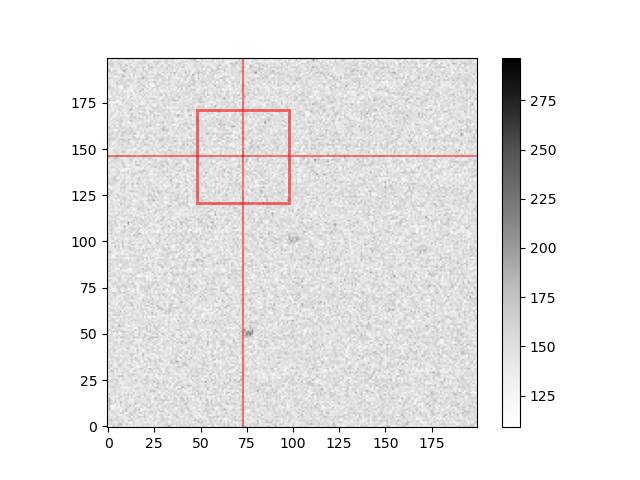

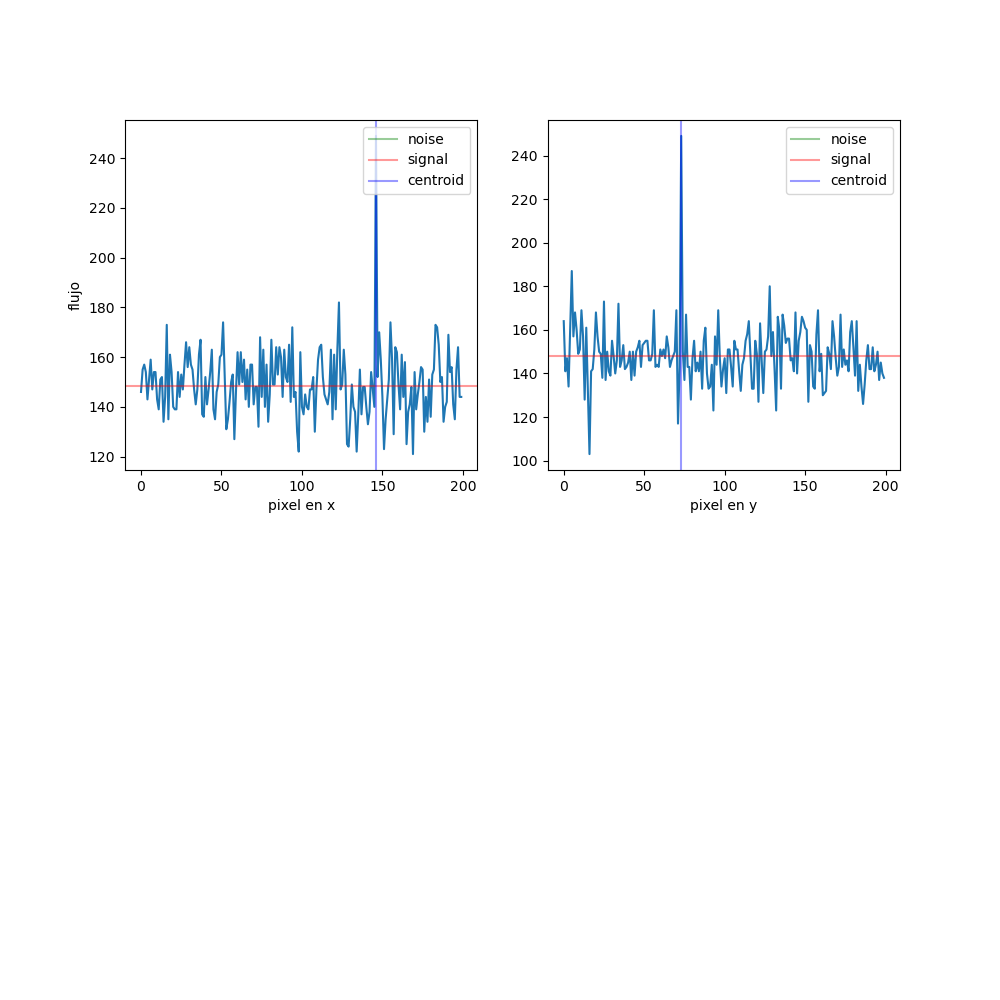

nan

In [30]:
%matplotlib widget
señal_ruido(ra, dec, 100, 50)

## Obtenemos las coordenadas como un objeto de astropy y calculamos el pixel donde se encuentra en nuestra imagen

In [18]:
coordenadas_estrella = SkyCoord(ra, dec, unit=u.deg, frame = ICRS)
w = WCS(header_new)

x_0, y_0 = w.world_to_pixel(coordenadas_estrella)
x_0 = int(x_0)
y_0 = int(y_0)

Set MJD-AVG to 59816.056115 from DATE-AVG.
Set MJD-END to 59816.056085 from DATE-END'. [astropy.wcs.wcs]


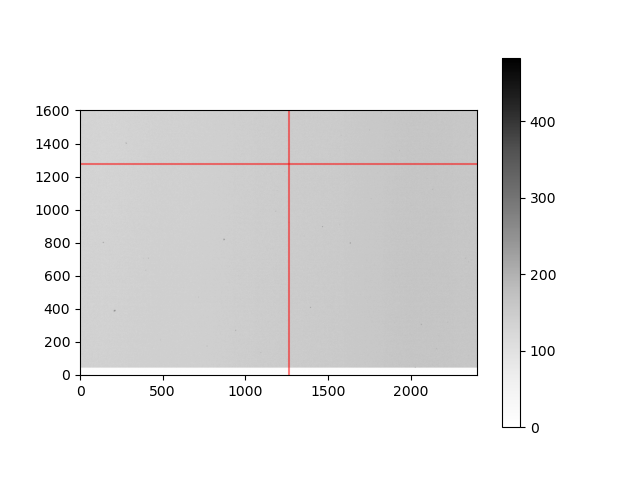

In [28]:
%matplotlib widget
plt.imshow(data, vmin=np.min(data)*2,cmap = 'Greys', vmax=np.mean(data)/0.3,origin='lower')

plt.axhline(y=int(y_0), color='r', linestyle='-', alpha= 0.5)
plt.axvline(x=int(x_0), color='r', linestyle='-', alpha=0.5)
#plt.imshow(region, vmin=np.min(r_data)*1.1, vmax=np.mean(r_data)/0.8,origin='lower')
plt.colorbar()
plt.show()